# Filtrage collaboratif

*ismael Bonneau*

Le filtrage collaboratif (en anglais: collaborative filtering) est une méthode utilisée par les systèmes de recommandations.

Elle permet de réaliser des prédictions automatiques ("filtrage") des intérêts d'un utilisateur en se basant sur les préférences d'un grand nombre d'autres utilisateurs ("collaboratif"), afin de recommander des produits (films, séries, musique, articles sur un site de e-commerce...) pertinents pour un utilisateur.

<img src="images/homer.png" width="500" />

-------------------------------------------------------------------------

### Principe:

L'hypothèse sous-jacente du filtrage collaboratif est que si une personne A a la même opinion qu'une personne B sur un sujet, A a plus de chance d'avoir la même opinion que B sur un autre sujet qu'une personne choisie au hasard.

Le système commence donc d'abord par collecter des avis d'un grand nombre d'utilisateurs sur un grand nombre d'objets (dans notre cas, des séries). Cet avis peut prendre plusieurs formes (1-5 étoiles, note sur 10, j'aime/je n'aime pas...) 

Puis, pour un utilisateur A le système trouve les utilisateurs qui ont les goûts les plus similaires. A partir des goûts de ces utilisateurs les plus similaires, le système peut prédir à l'utilisateur A une note pour chacun des objets qu'il n'a pas noté. 

Plusieurs types d'approche existent:

1) l'approche dite **memory-based**:
<p>
    Cette approche utilise les notes attribuées par les utilisateurs pour calculer la similarité entre les utilisateurs ou les objets. Elle se base sur un calcul de similarité et utilise des algorithmes classiques comme:
    <ul>
        <li>K plus proches voisins (K-NN) <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">wikipédia</a></li>
        <li>Des mesures de similarité comme la similarité cosinus, la corrélation de Pearson...
            <a href=""></a></li>
    </ul>
</p>

2) l'approche dite **model-based**: 
<p>
    Cette approche utilise des techniques de machine learning et de data mining pour attribuer des notes couples utilisateur-objet. 
<ul>
    <li>Analyse en composantes principales (PCA) <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition">wikipédia</a></li>
    <li>Factorisation de matrice non négative (NNMF) <a href="https://en.wikipedia.org/wiki/Non-negative_matrix_factorization">wikipédia</a></li>
    <li>Bayesian Personalized Ranking (n'attribue pas de "notes" mais un classement) <a href="https://cran.r-project.org/web/packages/rrecsys/vignettes/b6_BPR.html">lien</a></li>
    <li>...Et bien d'autres (approches à base de clustering...)</li>
</ul>
</p>

pour en savoir plus sur le filtrage collaboratif: <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">wikipédia (en anglais)</a>

<img src="images/Classification-of-collaborative-filtering-algorithms.png" width="600" />

image sources:

https://www.researchgate.net/profile/Kan_Zheng/publication/303556519/figure/fig4/AS:614297214414873@1523471277992/Classification-of-collaborative-filtering-algorithms.png

https://johnolamendy.wordpress.com/2015/10/14/collaborative-filtering-in-apache-spark/

### Notre but:

Nous allons mettre en oeuvre et comparer plusieurs approches de recommandation collaborative, en l'occurence les approches model-based. 

Notre but est d'implémenter et comparer qualitativement et quantitativement les algorithmes de factorisation de matrice non négative (NNMF), décomposition en valeurs singulières (SVD), Bayesian Personalized Ranking, et différentes fonctions de coûts associées, sur un jeu de données collectés sur le site imdb.

### Données:

Nous partons d'une base de ${m = 48705}$ utilisateurs ayant noté ${n = 892}$ séries. Ces données sont extraites du site <a href="https://www.imdb.com/">imdb</a> (voir script scraping/scraping.py) et sont résumées dans une matrice de taille ${n,m}$ où chaque entrée ${(u, i)}$ de matrice contient la note que l'utilisateur ${u}$ a attribué à l'item (série) ${i}$, sur 10 (le site ayant choisi un système de notation sur 10 étoiles).

---------------------

### Rentrons dans le vif du sujet:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import dok_matrix, csr_matrix #matrice "sparse"
from sklearn.decomposition import NMF, TruncatedSVD #matrix factorization, nous y reviendrons plus tard

import seaborn as sns
sns.set(color_codes=True)
plt.style.use('seaborn-white')
%matplotlib inline

filename = "userratings.csv"
tableSeries = "series.csv"

In [53]:
def MSE_err(truth,pred):
    """
    mean squarred error
    """
    return np.mean(np.power(np.array(truth-pred),2))

def MAE_err(truth,pred):
    """
    mean absolute error
    """
    return np.mean(np.abs(np.array(truth-pred)))

def pred_func(uid,iid):
    return np.dot(U[uid], I[iid])


def pred(uid,iid):
    return np.dot(U[uid], I[iid]) + umeans[uid]

### Récupérons les avis utilisateur

In [47]:
df = pd.read_csv(filename)

print("il y a {} utilisateurs et {} séries".format(df.shape[1], df.shape[0]))

il y a 48705 utilisateurs et 892 séries


**Ci dessous**, les premières lignes de la matrice, avec en ligne les séries et en colonne les utilisateurs. On peut voir que la plupart des cases sont vides (NaN), les utilisateurs n'ayant noté que très peu de séries.

In [115]:
df.head(4)

,bkoganbing,killer1h,santasa99,qui_j,BeneCumb,DegustateurDeChocolat,SonicStuart,DKosty123,jazebelle,insomniac_rod,...,chris_willson,michael-schaefer-34219,kevinmorice,mendelson77,pninson,montferrato,limona_razvan,kythia,Skylightmovies,bbgrl93
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Jetons un oeil à la distribution des données:

In [69]:
for seuil in [1, 5, 10]:
    c = len([a for a in (df.count(axis=0) > seuil) if a])/df.shape[1]
    print("{0:.2f}% des utilisateurs ont noté plus de ".format(
        100*c)+str(seuil)+" série ("+str(int(c*df.shape[1]))+" total)")
print("\n")   
for seuil in [2, 20, 50, 100]:
    c = len([a for a in (df.count(axis=1) > seuil) if a])/df.shape[0]
    print("{0:.2f}% des series ont reçu plus de ".format(
        100*c)+str(seuil)+" notes ("+str(int(c*df.shape[0]))+" total)")

13.55% des utilisateurs ont noté plus de 1 série (6598 total)
1.38% des utilisateurs ont noté plus de 5 série (670 total)
0.46% des utilisateurs ont noté plus de 10 série (226 total)


98.54% des series ont reçu plus de 2 notes (879 total)
69.62% des series ont reçu plus de 20 notes (621 total)
35.87% des series ont reçu plus de 50 notes (320 total)
19.28% des series ont reçu plus de 100 notes (172 total)


<img src="images/distribution_avis.png" width="900" />

L'histogramme révèle que les utilisateurs donnent très peu d'avis: 86,5% d'entre eux n'ont noté qu'une série. Les séries ont quant à elle plus d'avis: près de 20% des séries ont reçu plus de 100 notes, et 70% des séries ont reçu au moins 20 notes. Il faut choisir un **seuil de coupure** pour éliminer les utilisateurs ayant trop peu noté: nous choisissons arbitrairement de couper en-dessous de 4.

In [3]:
series = pd.read_csv(tableSeries)
series = series[["seriesname", "imdbId"]]

In [48]:
#nous allons réaliser un mapping des imdbId de séries vers des entiers.
#on mémorise le mapping entier -> série en gardant les noms de série.
df.rename(columns={"Unnamed: 0":'item'}, inplace=True)
serie_dict = []
for imdbId in df["item"]:
    serie_dict.append(list(series[series["imdbId"] == imdbId]["seriesname"])[0])

Retirons les noms de série, et enlevons les utilisateurs ayant noté moins de 5 séries:

In [49]:
df = df.drop(columns=['item']) #enlever la colonne des noms de série
df = df.loc[:, (df.count(axis=0) >= 4)] #enlever les utilisateurs ayant noté moins de 5 séries

On convertit le dataframe en matrice sparse scipy pour pouvoir travailler avec les algorithmes de machine learning. Une matrice "sparse" permet de stocker de manière efficace en mémoire des matrices de grande taille contenant peu de données, comme dans notre cas.

<img src="images/sparse_matrix.png" width="300" />

ci-dessus: un exemple de matrice sparse de taille ${8\times8 = 64}$ alors qu'elle contient seulement ${12}$ valeurs. Avec une structure adaptée à cette particularité, seules les 12 valeurs seront stockées en mémoire, sans réserver inutilement de la place pour 64 valeurs.

### passage en matrice sparse et construction du train/test set

In [50]:
mat = dok_matrix((df.values.shape[1], df.values.shape[0]), dtype=np.float32) #créer matrice sparse de dimension voulue
test = []

ind = 0
for i in range(df.values.shape[1]):
    for j in range(df.values.shape[0]):
        if not np.isnan(df.values[j,i]):
            if ind % 10 == 0:
                test.append((i,j,float(df.values[j,i])))
            else:
                mat[i,j] = float(df.values[j,i]) #on en profite pour transposer car le dataframe de base est en item x user
            ind += 1 
print("nouvelles dimensions de la matrice: ", mat.shape)
print("nombre de notes dans le train set ", mat.nnz)
print("nombre de notes dans le test set ", len(test))

nouvelles dimensions de la matrice:  (1423, 892)
nombre de notes dans le train set  10775
nombre de notes dans le test set  1198


Et voilà notre matrice sparse! Nos données sont prêtes, nous pouvons passer à l'étape suivante.

### Non-negative Matrix Factorization:

Une des façons de faire du filtrage collaboratif par approche model-based est d'utiliser un algorithme de **factorisation de matrice**. 

On pose $\mathbf{R}$ la matrice que l'on cherche à prédire, contenant toutes les notes existantes et prédites. Cette matrice est de dimension ${m, n}$ avec ${m}$ le nombre d'utilisateurs et ${n}$ le nombre de séries. On va chercher à trouver deux matrices "facteur" $\mathbf{U}$ et $\mathbf{I}$ de dimension ${m, k}$ et ${k, n}$ de telle sorte que $\mathbf{R}\approx\mathbf{U}\cdot\mathbf{I}$

<img src="images/collaborative_filtering.png" width="400" />

Les dimensions ${m}$ et ${n}$ étant connues à l'avance, c'est la dimension ${k}$ qu'il reste à fixer, et définir une "fonction" mathématique qui mesure à quel point les deux matrice $\mathbf{R}$ (reconstituée) et la matrice originale sont proches.

Ainsi, et d'après la définition du produit matriciel, chaque case de la matrice $R_{i,j}$ résultante est le résultat d'une combinaison linéaire de $U_{i,}$ et $I_{,j}$, c'est à dire d'un vecteur de dimension ${k}$ représentant l'utilisateur ${i}$ et d'un vecteur de dimension ${k}$ représentant l'item ${j}$.

Il s'agit donc de projeter les utilisateurs et les items dans un espace de dimension ${k}$ !

Plusieurs algorithmes peuvent servir à réaliser une factorisation de matrice.

### NMF (non negative matrix factorization)

L'algorithme décompose ${R}$ comme un produit de 2 matrices ${R\approx U\cdot I^\top}$. insérer fonction objective et autres formules ici. Parler de régularization (alpha, l1_ratio)

In [52]:
#n_components: le paramètre k
model = NMF(n_components=150, solver='cd' ,random_state=0, max_iter=200, alpha=0.)
#nous toucherons aux autres paramètres après
U = model.fit_transform(mat) #utilisateurs
I = model.components_ #items
#sigma = np.diag(model2.singular_values_) #sigma, sous forme de matrice diagonale
I = I.transpose()

print(U.shape, I.shape)

(1423, 150) (892, 150)


#### Evolution de l'erreur train/test en fonction du paramère K:

Regardons l'erreur MSE et MAE sur les ensembles train et test pour différentes valeurs de ${k}$ afin d'étudier l'impact de ce paramètre.

<img src="images/NMFerrorK(without_regularization).png" width="700" />

#### résultat: 

l'erreur sur l'ensemble d'apprentissage diminue quand ${k}$ augmente, mais l'erreur sur l'ensemble de test augmente. Ceci peut être dû à un phénomène de sur apprentissage, étant donné que nous n'avons introduit aucune régularisation.

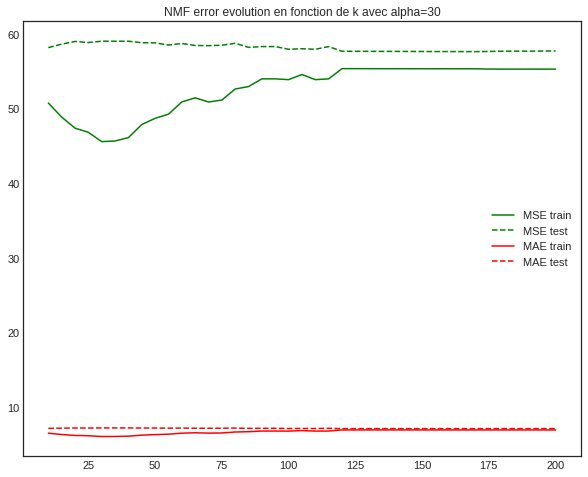

In [84]:
x = list(range(10, 205, 5))

plt.figure(figsize=(10,8))
plt.title(r"NMF error evolution en fonction de k avec alpha=30")
plt.plot(x, mse_train, color="green", label="MSE train")
plt.plot(x, mse_test, color="green", label="MSE test", linestyle="dashed")
plt.plot(x, mae_train, color="red", label="MAE train")
plt.plot(x, mae_test, color="red", label="MAE test", linestyle="dashed")
plt.legend()
plt.savefig("images/NMFerrorKalpha=30.png")
plt.show()

### SVD (singular value decomposition)

L'algorithme décompose donc ${R}$ comme un produit de 2 matrices ${R\approx U\cdot I^\top}$. Le paramètre k est très important. 

Comme nos données sont normalisées de façon à ne modéliser que la déviation par rapport à la moyenne, la règle de prédiction sera: ${r_{u,i} = \mu_{u}+U_u\cdot I_i^\top}$


Avant de convertir les données en matrice sparse, nous allons les normaliser: nous allons centrer les données, c'est à dire soustraire à chaque colonne (chaque utilisateur) sa moyenne. Ainsi chaque note sera normalisée par rapport à la moyenne des notes données par cet utilisateur.

In [6]:
umeans = []
for user in df:
    mean = df[user].mean()
    df[user] = df[user] - mean
    umeans.append(mean)
    
mat = dok_matrix((df.values.shape[1], df.values.shape[0]), dtype=np.float32) #créer matrice sparse de dimension voulue
test = []

ind = 0
for i in range(df.values.shape[1]):
    for j in range(df.values.shape[0]):
        if not np.isnan(df.values[j,i]):
            if ind % 10 == 0:
                test.append((i,j,float(df.values[j,i])))
            else:
                mat[i,j] = float(df.values[j,i]) #on en profite pour transposer car le dataframe de base est en item x user
            ind += 1 
print("nouvelles dimensions de la matrice: ", mat.shape)
print("nombre de notes dans le train set ", mat.nnz)
print("nombre de notes dans le test set ", len(test))

In [24]:
#n_components: le paramètre k
model = TruncatedSVD(n_components=150)
U = model.fit_transform(mat) #utilisateurs
I = model.components_ #items
#sigma = np.diag(model2.singular_values_) #sigma, sous forme de matrice diagonale
I = I.transpose()

print(U.shape, I.shape)

(1423, 150) (892, 150)


On obtient bien les matrices voulues dans les bonnes dimensions.

In [36]:
mse_train = []
mse_test = []
mae_train = []
mae_test = []

for i in range(10, 205, 5):
    
    model = TruncatedSVD(n_components=i)
    U = model.fit_transform(mat) #utilisateurs
    I = model.components_.transpose() #items
    
    truth_tr = np.array([rating for (uid,iid),rating in mat.items()])
    truth_te = np.array([rating for uid,iid,rating in test])

    prediction_tr = np.array([pred_func(u,i) for (u,i),rating in mat.items()])
    prediction_te = np.array([pred_func(u,i) for u,i,rating in test])
    
    mse_train.append(MSE_err(prediction_tr,truth_tr))
    mae_train.append(MAE_err(prediction_tr,truth_tr))
    mse_test.append(MSE_err(prediction_te,truth_te))
    mae_test.append(MAE_err(prediction_te,truth_te))

<img src="images/SVDevolutionK.png" width="500" />